In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/test/benign/melanoma_9697.jpg
/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/test/benign/melanoma_10087.jpg
/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/test/benign/melanoma_9618.jpg
/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/test/benign/melanoma_9614.jpg
/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/test/benign/melanoma_9862.jpg
/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/test/benign/melanoma_9838.jpg
/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/test/benign/melanoma_9851.jpg
/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/test/benign/melanoma_9691.jpg
/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/test/benign/

# Import Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
)
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.regularizers import L2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing import image


2025-11-11 15:50:05.953725: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762876206.114964      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762876206.163114      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

# Configuration Class

In [3]:
class Config:
    
    DATA_PATH = "/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset"
    TRAIN_PATH = os.path.join(DATA_PATH, "train")
    TEST_PATH = os.path.join(DATA_PATH, "test")
    
    # Model settings
    IMG_SIZE = (224, 224)
    BATCH_SIZE = 32
    EPOCHS = 25
    LEARNING_RATE = 0.0001  
    
    # Regularization
    L2_PENALTY = 1e-4
    DROPOUT_RATE = 0.5  
    LABEL_SMOOTHING = 0.1 
    
    # Classes
    CLASSES = ['benign', 'malignant']
    NUM_CLASSES = 2
    
    # Output paths
    MODEL_PATH = "best_optimized_model.keras"
    WEIGHTS_PATH = "best_optimized_weights.h5"

# Cosine Annealing Learning Rate Scheduler

In [4]:
def cosine_annealing_scheduler(epoch, initial_lr=0.001, T_max=30):
    """
    Cosine annealing learning rate scheduler with warm restarts
    Helps escape local minima and improves generalization
    """
    lr = initial_lr * (1 + np.cos(np.pi * epoch / T_max)) / 2
    return max(lr, 1e-7)

In [5]:

train_dir = Config.TRAIN_PATH
test_dir = Config.TEST_PATH

for split, path in [('Train', train_dir), ('Test', test_dir)]:
    print(f"\n{split} Data Summary:")
    for cls in os.listdir(path):
        cls_path = os.path.join(path, cls)
        print(f"  {cls:10s}: {len(os.listdir(cls_path))} images")


Train Data Summary:
  benign    : 5000 images
  malignant : 4605 images

Test Data Summary:
  benign    : 500 images
  malignant : 500 images


# Sample Images

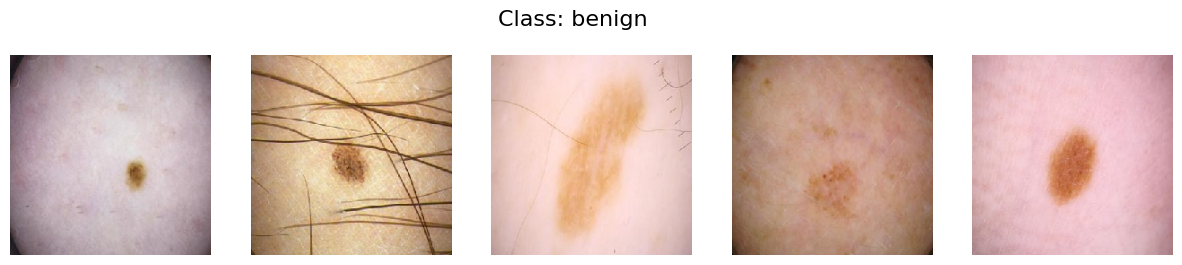

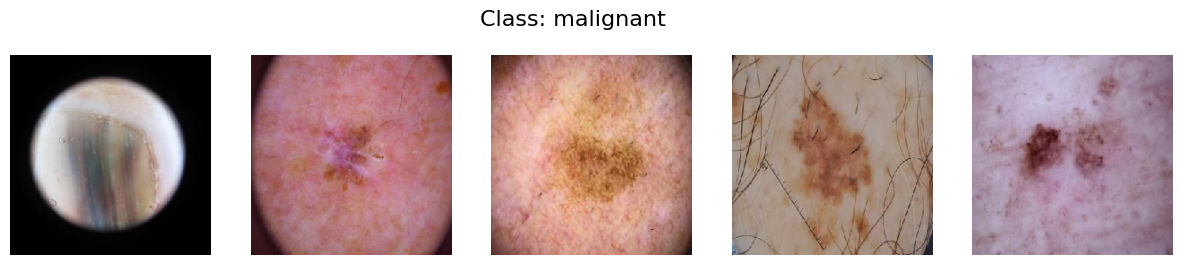

In [6]:
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing import image

for cls in Config.CLASSES:
    folder = os.path.join(Config.TRAIN_PATH, cls)
    samples = random.sample(os.listdir(folder), 5)

    plt.figure(figsize=(15, 3))
    for i, img_name in enumerate(samples):
        img_path = os.path.join(folder, img_name)
        img = image.load_img(img_path, target_size=Config.IMG_SIZE)
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f"Class: {cls}", fontsize=16)
    plt.show()

# Image Dimension Distribution


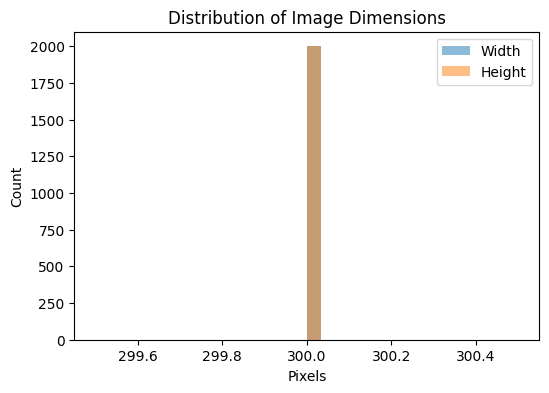

In [7]:
from PIL import Image


sizes = []
for cls in Config.CLASSES:
    folder = os.path.join(Config.TRAIN_PATH, cls)
    for img_name in os.listdir(folder)[:1000]:  
        img_path = os.path.join(folder, img_name)
        with Image.open(img_path) as img:
            sizes.append(img.size)

widths, heights = zip(*sizes)
plt.figure(figsize=(6,4))
plt.hist(widths, bins=30, alpha=0.5, label='Width')
plt.hist(heights, bins=30, alpha=0.5, label='Height')
plt.legend()
plt.title("Distribution of Image Dimensions")
plt.xlabel("Pixels")
plt.ylabel("Count")
plt.show()


# Dataset Class Distribution

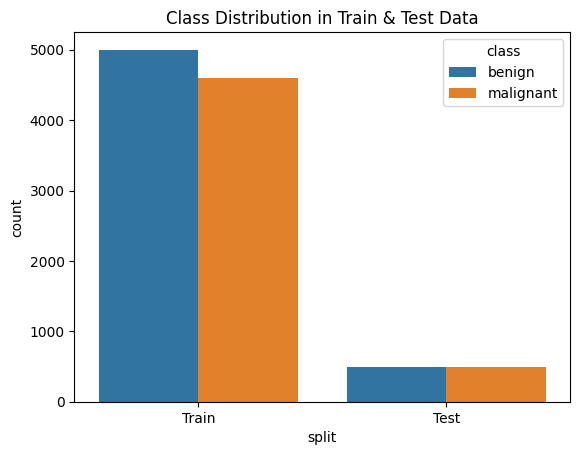

In [8]:

data_counts = []
for split, path in [('Train', train_dir), ('Test', test_dir)]:
    for cls in os.listdir(path):
        n = len(os.listdir(os.path.join(path, cls)))
        data_counts.append({'split': split, 'class': cls, 'count': n})

df = pd.DataFrame(data_counts)
sns.barplot(x='split', y='count', hue='class', data=df)
plt.title("Class Distribution in Train & Test Data")
plt.show()

# DullRazor Hair Removal and CLAHE Enhancement

In [9]:
import cv2
import numpy as np

def dull_razor(image_path):
    """
    Returns:
        tuple: (inpainted_rgb, gray, blackhat, hair_mask, enhanced_rgb)
               Hair-removed image, intermediate steps, and enhanced output.
    """
    # Read image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image not found: {image_path}")
    
    # Convert to grayscale (BGR -> Gray)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply black-hat filter to detect hairs
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    
    # Threshold the black-hat result to get hair mask
    _, hair_mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)

    # Inpaint the hair pixels
    inpainted = cv2.inpaint(img, hair_mask, 2, cv2.INPAINT_TELEA)
    
    # ----- Apply CLAHE to improve local contrast -----
    # Convert to LAB color space
    lab = cv2.cvtColor(inpainted, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE on the L (lightness) channel
    clahe = cv2.createCLAHE(clipLimit=0.4, tileGridSize=(8,8))
    cl = clahe.apply(l)

    # Merge enhanced L with original A and B channels
    limg = cv2.merge((cl, a, b))

    # Convert back to BGR and then to RGB for visualization
    enhanced = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    inpainted_rgb = cv2.cvtColor(inpainted, cv2.COLOR_BGR2RGB)
    enhanced_rgb = cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB)
    
    return inpainted_rgb, gray, blackhat, hair_mask, enhanced_rgb


In [10]:
import os
import cv2
from tqdm import tqdm

def preprocess_dataset_for_hair_removal(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    # Loop through all class folders (e.g., benign / malignant)
    for cls in os.listdir(input_dir):
        cls_input = os.path.join(input_dir, cls)
        cls_output = os.path.join(output_dir, cls)

        if not os.path.isdir(cls_input):
            continue  # skip non-folder files

        os.makedirs(cls_output, exist_ok=True)

        # tqdm for nice progress visualization
        for file in tqdm(os.listdir(cls_input), desc=f"Processing {cls}"):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                input_path = os.path.join(cls_input, file)
                output_path = os.path.join(cls_output, file)

                try:
                    # Call your DullRazor + CLAHE function
                    inpainted_rgb, gray, blackhat, hair_mask, enhanced_rgb = dull_razor(input_path)

                    # Save only the final enhanced image
                    cv2.imwrite(output_path, cv2.cvtColor(enhanced_rgb, cv2.COLOR_RGB2BGR))

                except Exception as e:
                    print(f"Skipped {file}: {e}")

In [11]:
preprocess_dataset_for_hair_removal(Config.TRAIN_PATH, "/kaggle/working/clean_train")
preprocess_dataset_for_hair_removal(Config.TEST_PATH, "/kaggle/working/clean_test")

Config.TRAIN_PATH = "/kaggle/working/clean_train"
Config.TEST_PATH = "/kaggle/working/clean_test"

Processing malignant: 100%|██████████| 500/500 [00:10<00:00, 48.82it/s]


# Sample Visualization of DullRazor + CLAHE

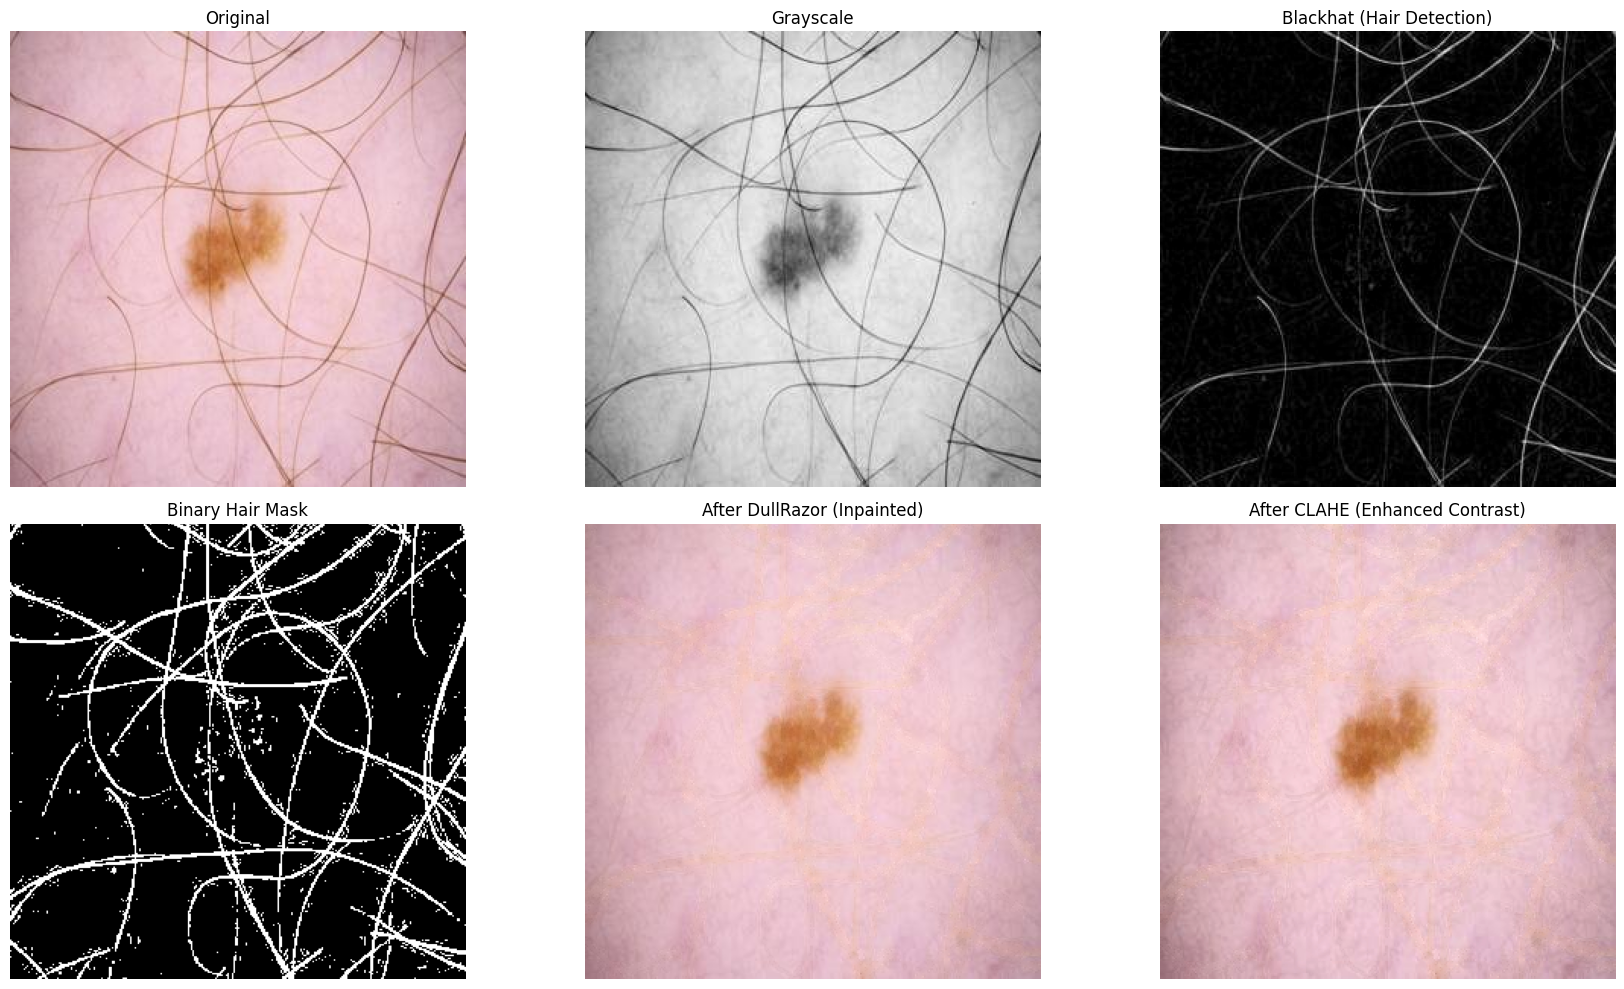

In [12]:
image_path = "/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/train/benign/melanoma_3.jpg"

import cv2
import matplotlib.pyplot as plt

# Run DullRazor (with CLAHE enhancement)
inpainted_rgb, gray, blackhat, hair_mask, enhanced_rgb = dull_razor(image_path)

# Read original image in RGB for plotting
original_img = cv2.imread(image_path)
original_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Plot all images
plt.figure(figsize=(18, 10))

# Original
plt.subplot(2, 3, 1)
plt.imshow(original_rgb)
plt.title("Original")
plt.axis("off")

#  Grayscale
plt.subplot(2, 3, 2)
plt.imshow(gray, cmap='gray')
plt.title("Grayscale")
plt.axis("off")

#  Blackhat
plt.subplot(2, 3, 3)
plt.imshow(blackhat, cmap='gray')
plt.title("Blackhat (Hair Detection)")
plt.axis("off")

#  Hair Mask
plt.subplot(2, 3, 4)
plt.imshow(hair_mask, cmap='gray')
plt.title("Binary Hair Mask")
plt.axis("off")

#  After DullRazor (Inpainting)
plt.subplot(2, 3, 5)
plt.imshow(inpainted_rgb)
plt.title("After DullRazor (Inpainted)")
plt.axis("off")

#  After CLAHE Enhancement
plt.subplot(2, 3, 6)
plt.imshow(enhanced_rgb)
plt.title("After CLAHE (Enhanced Contrast)")
plt.axis("off")

plt.tight_layout()
plt.show()


# Data Generator Setup for Training, Validation, and Testing

In [13]:
def setup_data_generators():
   
    print("Setting up data generators...")
    
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,  
        width_shift_range=0.15, 
        height_shift_range=0.15,  
        horizontal_flip=True,
        zoom_range=0.15, 
        shear_range=0.1, 
        fill_mode='nearest',
        validation_split=0.2
    )
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(
        Config.TRAIN_PATH,
        target_size=Config.IMG_SIZE,
        batch_size=Config.BATCH_SIZE,
        class_mode='binary',
        subset='training',
        shuffle=True,
        seed=42
    )
    
    validation_generator = train_datagen.flow_from_directory(
        Config.TRAIN_PATH,
        target_size=Config.IMG_SIZE,
        batch_size=Config.BATCH_SIZE,
        class_mode='binary',
        subset='validation',
        shuffle=True,
        seed=42
    )
    
    test_generator = test_datagen.flow_from_directory(
        Config.TEST_PATH,
        target_size=Config.IMG_SIZE,
        batch_size=Config.BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )
    
    print(f" Data generators created!")
    print(f" Training samples: {train_generator.samples}")
    print(f" Validation samples: {validation_generator.samples}")
    print(f"Test samples: {test_generator.samples}")
    
    return train_generator, validation_generator, test_generator


train_gen, val_gen, test_gen = setup_data_generators()

Setting up data generators...
Found 7684 images belonging to 2 classes.
Found 1921 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
 Data generators created!
 Training samples: 7684
 Validation samples: 1921
Test samples: 1000


# DenseNet121 Model

In [14]:
def create_densenet_model():
    
    print(" Building  DenseNet121 model...")
    config =Config()
    
    # Load pre-trained DenseNet121
    base_model = DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=(*config.IMG_SIZE, 3)
    )
    
    # Fine-tuning: Unfreeze last 60 layers
    base_model.trainable = True
    for layer in base_model.layers[:-60]:
        layer.trainable = False
    
    # Build enhanced classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    # First dense block with BatchNorm
    x = Dense(512, kernel_regularizer=L2(config.L2_PENALTY))(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = Dropout(config.DROPOUT_RATE)(x)
    
    # Second dense block for additional capacity
    x = Dense(256, kernel_regularizer=L2(config.L2_PENALTY))(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = Dropout(config.DROPOUT_RATE)(x)
    
    # Output layer
    predictions = Dense(1, activation='sigmoid')(x)
    
    # Create model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compile with label smoothing loss
    model.compile(
        optimizer=Adam(learning_rate=config.LEARNING_RATE),
        loss=BinaryCrossentropy(label_smoothing=config.LABEL_SMOOTHING),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    
    print(" Model created and compiled!")
    print(f" Total parameters: {model.count_params():,}")
    trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    print(f" Trainable parameters: {trainable_params:,}")
    
    return model

model = create_densenet_model()
model.summary()

 Building  DenseNet121 model...


I0000 00:00:1762876440.688817      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762876440.689534      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
 Model created and compiled!
 Total parameters: 7,696,961
 Trainable parameters: 1,908,993


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,696,961 (29.36 MB)

 Trainable params: 1,908,993 (7.28 MB)

 Non-trainable params: 5,787,968 (22.08 MB)

In [15]:
def setup_callbacks():
    """Enhanced callbacks with cosine annealing scheduler"""
    config = Config()
    
    callbacks = [
        ModelCheckpoint(
            config.MODEL_PATH,
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=False,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=12,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.3,  # More aggressive reduction
            patience=4,
            min_lr=1e-7,
            verbose=1
        ),
        LearningRateScheduler(
            lambda epoch: cosine_annealing_scheduler(
                epoch, 
                initial_lr=config.LEARNING_RATE,
                T_max=config.EPOCHS
            ),
            verbose=1
        )
    ]
    
    return callbacks


# Model Training

In [16]:

def train_model(model, train_gen, val_gen):
    print(" Starting  training...")
    config = Config()
    
    callbacks = setup_callbacks()
    
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=config.EPOCHS,
        callbacks=callbacks,
        verbose=1
    )
    
    print(" Training completed!")
    return history

history = train_model(model, train_gen, val_gen)


 Starting  training...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/25


I0000 00:00:1762876467.502892      92 service.cc:148] XLA service 0x7a7cfc025170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762876467.503669      92 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762876467.503695      92 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762876471.295267      92 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/241 ━━━━━━━━━━━━━━━━━━━━ 2:54:38 44s/step - accuracy: 0.5625 - loss: 0.9663 - precision: 0.5769 - recall: 0.8333

I0000 00:00:1762876490.923258      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.7298 - loss: 0.6962 - precision: 0.7088 - recall: 0.7620
Epoch 1: val_accuracy improved from -inf to 0.88235, saving model to best_optimized_model.keras
241/241 ━━━━━━━━━━━━━━━━━━━━ 190s 608ms/step - accuracy: 0.7300 - loss: 0.6958 - precision: 0.7091 - recall: 0.7620 - val_accuracy: 0.8824 - val_loss: 0.4799 - val_precision: 0.9338 - val_recall: 0.8122 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.96057350657239e-05.
Epoch 2/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.8564 - loss: 0.5323 - precision: 0.8657 - recall: 0.8317
Epoch 2: val_accuracy improved from 0.88235 to 0.90890, saving model to best_optimized_model.keras
241/241 ━━━━━━━━━━━━━━━━━━━━ 106s 440ms/step - accuracy: 0.8564 - loss: 0.5323 - precision: 0.8658 - recall: 0.8317 - val_accuracy: 0.9089 - val_loss: 0.4364 - val_precision: 0.9357 - val_recall: 0.8697 - learning_rate: 9.9606e-05

Epoch 3: LearningRateSch

# Plot Training and Validation Accuracy & Loss

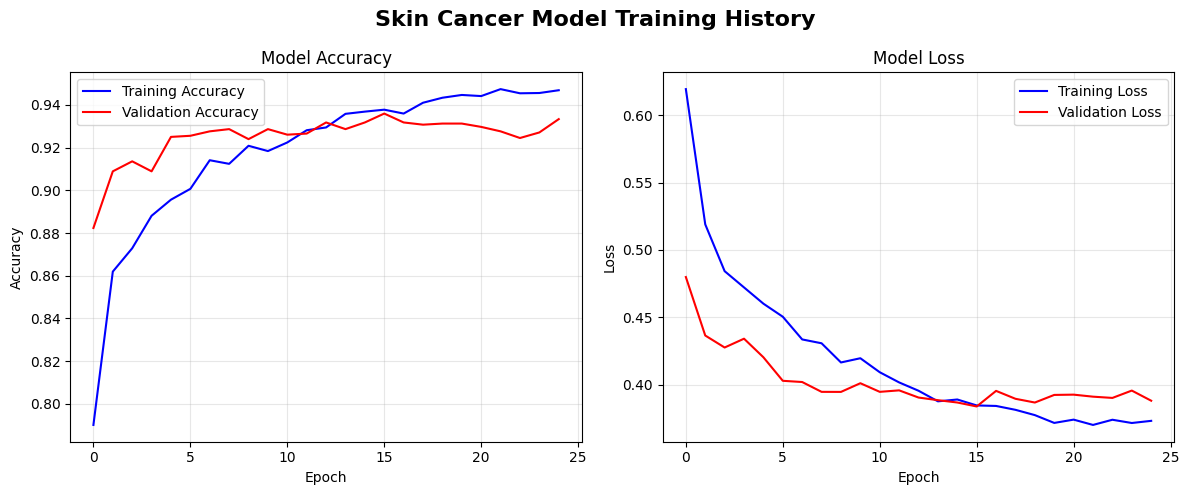

In [17]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plot only Training & Validation Accuracy and Loss
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('Skin Cancer Model Training History', fontsize=16, fontweight='bold')

    # ---- Accuracy ----
    axes[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # ---- Loss ----
    axes[1].plot(history.history['loss'], label='Training Loss', color='blue')
    axes[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
plot_training_history(history)

# Model Evaluation and ROC-AUC Analysis

Evaluating model on test data...
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 550ms/step

 TEST RESULTS:
Test Accuracy: 0.9270
Test Precision: 0.9591
Test Recall: 0.8920
Test Loss: 0.4111

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      benign       0.90      0.96      0.93       500
   malignant       0.96      0.89      0.92       500

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



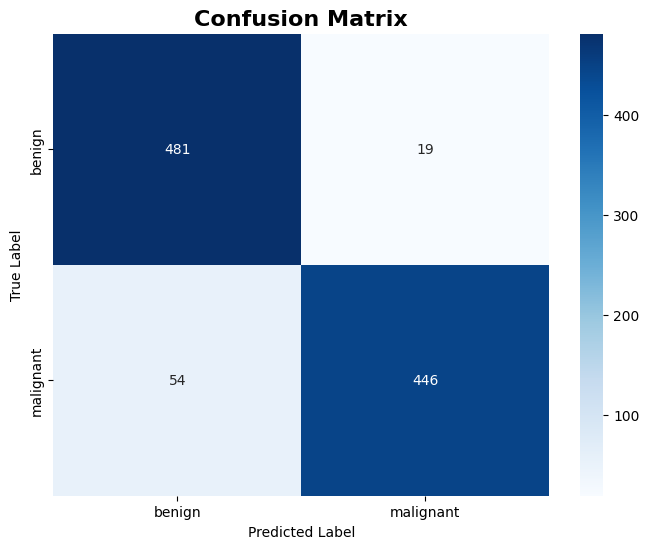

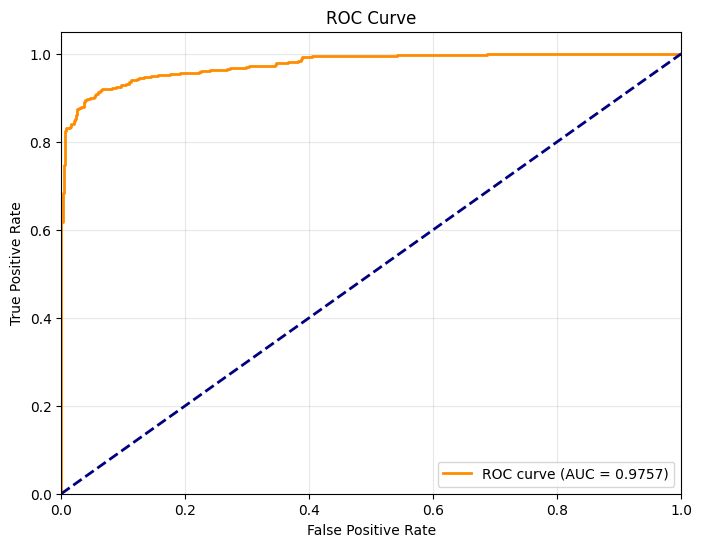

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

def evaluate_model(model, test_generator):
    """
     Evaluate model on test data and plot confusion matrix + ROC-AUC
    """
    print("Evaluating model on test data...")
    config=Config()
    # Get predictions
    test_generator.reset()
    predictions = model.predict(test_generator, verbose=1)
    y_pred = (predictions > 0.5).astype(int)
    y_true = test_generator.classes

    # Calculate metrics
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator, verbose=0)

    print(f"\n TEST RESULTS:")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    # Classification report
    print("\nCLASSIFICATION REPORT:")
    print(classification_report(y_true, y_pred, target_names=config.CLASSES))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=config.CLASSES, yticklabels=config.CLASSES)
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    # ------------------- ROC-AUC Curve -------------------
    fpr, tpr, _ = roc_curve(y_true, predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.savefig('roc_auc_curve.png', dpi=300, bbox_inches='tight')
    plt.show()

    return test_accuracy, test_precision, test_recall
test_accuracy, test_precision, test_recall = evaluate_model(model, test_gen)



#   XAI IMPLEMENTATION: GRAD-CAM


In [19]:


import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model

class GradCAM:
    """Generate Grad-CAM visualizations for CNN models"""
    
    def __init__(self, model, layer_name):
       
        self.model = model
        self.layer_name = layer_name
        self.grad_model = Model(
            inputs=model.input,
            outputs=[model.get_layer(layer_name).output, model.output]
        )
    
    def generate(self, img_array):
        """
        Generate Grad-CAM heatmap
        
        Args:
            img_array: Input image array with shape (1, H, W, C)
            
        Returns:
            heatmap: Normalized heatmap with shape (H_conv, W_conv)
            pred_index: Index of the predicted class
            pred_prob: Probability of the predicted class
        """
        img_array = np.expand_dims(img_array, 0) if img_array.ndim == 3 else img_array
        
        with tf.GradientTape() as tape:
            conv_outputs, predictions = self.grad_model(img_array)
            pred_index = tf.argmax(predictions[0])
            class_channel = predictions[:, pred_index]
        
        # Compute gradients of the top predicted class
        grads = tape.gradient(class_channel, conv_outputs)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        
        # Weight conv layer outputs by gradients
        conv_outputs = conv_outputs[0]
        heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        
        # Normalize between 0 and 1
        heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
        
        pred_prob = predictions[0][pred_index].numpy()
        
        return heatmap.numpy(), int(pred_index.numpy()), float(pred_prob)

def visualize_gradcam(image, heatmap, pred_label, pred_prob, class_names, 
                      true_label=None, save_path=None):
   
    # Convert to uint8 if needed
    if image.max() <= 1:
        image = (image * 255).astype(np.uint8)
    else:
        image = image.astype(np.uint8)
    
    # Resize heatmap to image size
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    
    # Superimpose heatmap on original image
    superimposed = cv2.addWeighted(image, 0.6, heatmap_colored, 0.4, 0)
    
    # Plot results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    im = axes[1].imshow(heatmap_resized, cmap='jet')
    axes[1].set_title('Grad-CAM Heatmap')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1])
    
    axes[2].imshow(cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB))
    title = f'Pred: {pred_label} ({pred_prob:.2%})'
    if true_label:
        title = f'True: {true_label}\n{title}'
    axes[2].set_title(title)
    axes[2].axis('off')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# 3. IMAGE LOADING UTILITY
def load_image(image_path, target_size=(224, 224)):
    """
    Load and preprocess a single image
    """
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image: {image_path}")
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0
    return img

# 4. MAIN FUNCTION TO RUN GRAD-CAM
def run_gradcam(image_path, layer_name, model_path="/kaggle/working/best_optimized_model.keras", class_names=None):
    """
    Run Grad-CAM in one command:
    - Loads model
    - Loads image
    - Generates Grad-CAM
    - Visualizes result
    """
    # Load model
    print(" Loading model...")
    model = tf.keras.models.load_model(model_path)
    
    # Load and preprocess image
    print(f"Loading image: {image_path}")
    image = load_image(image_path)
    
    # Generate Grad-CAM
    gradcam = GradCAM(model, layer_name)
    heatmap, pred_idx, pred_prob = gradcam.generate(image)
    
    # Class label
    if class_names is None:
        class_names = [f"Class {i}" for i in range(model.output_shape[-1])]
    pred_label = class_names[pred_idx]
    
    # Visualize
    visualize_gradcam(image, heatmap, pred_label, pred_prob, class_names)
    print(f"Done! Predicted: {pred_label} ({pred_prob:.2%})")


 Loading model...
Loading image: /kaggle/working/clean_test/benign/melanoma_9702.jpg


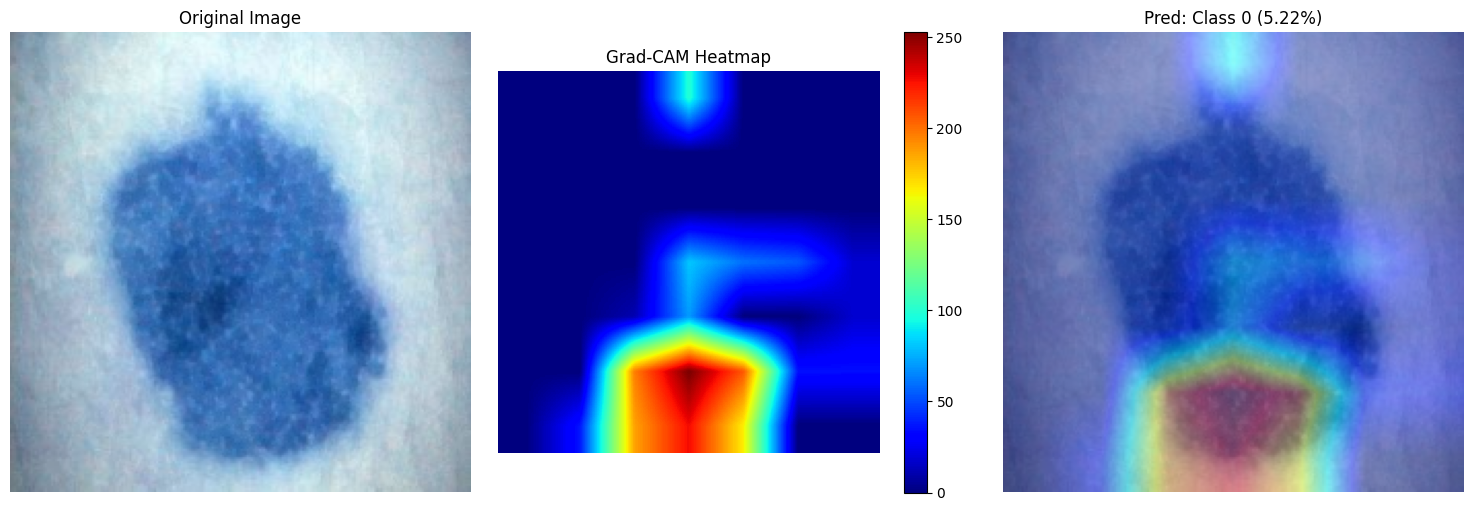

Done! Predicted: Class 0 (5.22%)


In [20]:
 run_gradcam("/kaggle/working/clean_test/benign/melanoma_9702.jpg", "relu")